In [1]:
#%matplotlib
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import scipy.integrate as sc
import scipy.optimize as optimize
import scipy.interpolate

import matplotlib.pyplot as plt
import scipy.integrate as inv

import scipy.special as special
from time import time
from scipy.optimize import curve_fit
from scipy.optimize import fsolve


0.0012484394506866417
løsningnen til differnetialligningen er $y = aD - \frac{2c_1}{\sqrt{a}}+c_2$
løsningnen til differnetialligningen er $y = aD-2c1/sqrt(a)+c_2$


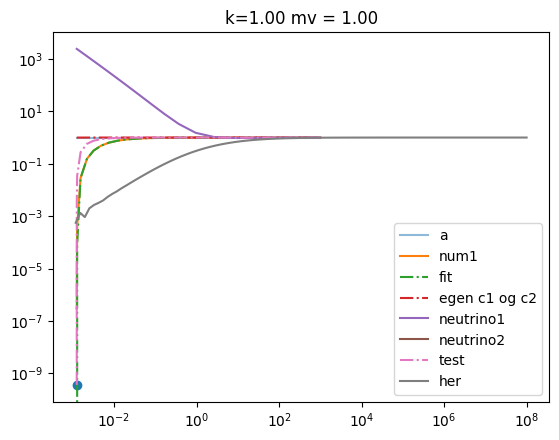

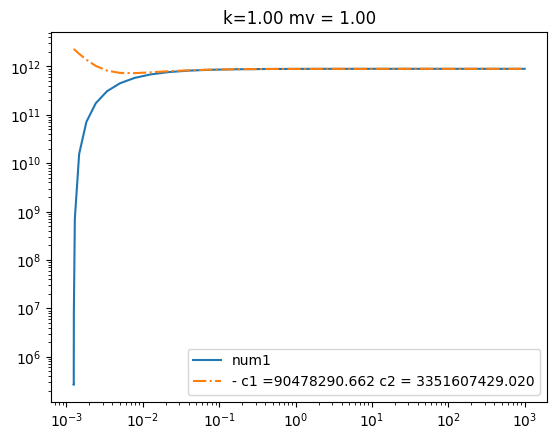

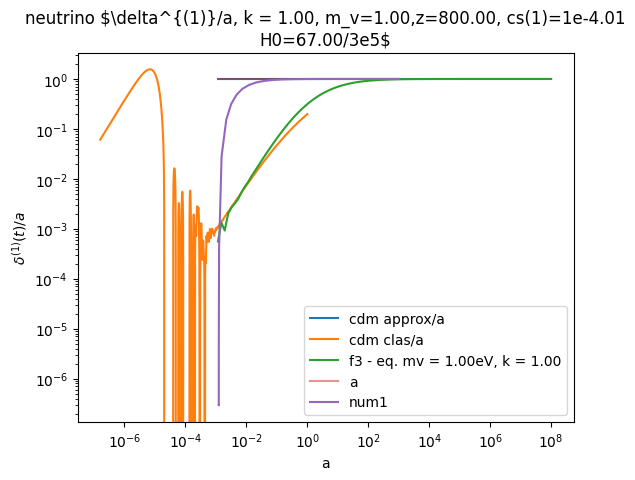

In [2]:
def TEST6(kvec=[1],k_ind=0,z=800,mv_test=1,Omega_M=0.99,
         Omega_b=0.01,PLOT_FIGUR=True,EdSitter=True,
         interpolation_type="cubic",H0_override=False,H=67):
    
    
    def Power(x,k):
        return np.power(x,k)
    def Cos(x):
        return np.cos(x)
    def Sin(x):
        return np.sin(x)
    def CosIntegral(x):
        return special.sici(x)[1]
    def SinIntegral(x):
        return special.sici(x)[0]
    def Sqrt(x):
        return np.sqrt(x)
    def Sinc(x):
        return np.sinc(x)
    Omega_lambda = 1 - Omega_M - Omega_b
    cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
    cs_factor /= 4
    factor = cs_factor
    k = kvec[k_ind]
    H0=67
    if H0_override == True:
        H0 =H
    Tv_k = 1.947
    # in MeV
    h = 0.6704
    kb = 8.617e-11 # MeV/K
    T_0 = Tv_k * kb
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M,'Omega_b':Omega_b, 'k_output_values':str(kvec).strip('[]')
                 ,"N_ncdm":1,"m_ncdm":mv_test # massen er givet i eV s' jeg ganger min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                , "YHe":0.25
                }
    c = 3*1e5 # speed of lign in km/s
    H0 /= c # i 1/Mpc
    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    pts = cosmo.get_perturbations()['scalar']
    # Here we create/import the powerspectrum values from class
    tranf = cosmo.get_transfer(z=0)
    prim = cosmo.get_primordial()
    k = tranf['k (h/Mpc)'] * h
    
    tid = bg['proper time [Gyr]'] * c / 306.4
    d_m_af_k =  scipy.interpolate.interp1d(k,tranf["d_m"])
    prim_interp = scipy.interpolate.interp1d(prim["k [1/Mpc]"],prim["P_scalar(k)"], fill_value="extrapolate",kind="linear")
    p = lambda k: 2*np.pi**2 * d_m_af_k(k)** 2 *  prim_interp(k) * h**3  *k**(-3)    
    kvec = np.array(kvec)
    mv = mv_test * 1e-6
    t0_test = tid[-1]
    def cs(a):
        Tv_k = 1.947 # kelvin # MeV
        kb = 8.617e-11 # MeV/K
        T_0 = Tv_k * kb
        mv = mv_test * 1e-6
        cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
        cs_factor /= 8
        return cs_factor *T_0 / a / mv
    c = cs(1)
    def test(kind,z_slut=0):
        c = cs(1)
        k = kvec[kind]
        delta_class = pts[kind]["delta_cdm"]
        theta_neutrino_class = pts[kind]["theta_ncdm[0]"]
        delta_neutrino_class = pts[kind]["delta_ncdm[0]"]        
        a_class = pts[kind]["a"]
        tau_class = pts[kind]["tau [Mpc]"]
        tid_class = scipy.interpolate.interp1d(bg['conf. time [Mpc]'],tid)(tau_class)
        interp_tid_from_a = scipy.interpolate.interp1d(a_class,tid_class,kind=interpolation_type,)
        delta_interp = scipy.interpolate.interp1d(tid_class,delta_class,kind=interpolation_type)        
        theta_neu_tid = scipy.interpolate.interp1d(tid_class,theta_neutrino_class)
        neu_tid = scipy.interpolate.interp1d(tid_class,delta_neutrino_class)        
        a0 = 1/(1+z)
        aslut = 1/(1+z_slut)
        t0 = interp_tid_from_a(aslut)
        T0 = float(interp_tid_from_a(a0)) # a0**(3/2) * t0
        delta0 = delta_interp(T0)  
        a_span = [a0,aslut]
        
        
        tspan = [T0,t0]    
        bonus_tid = 1_000_000_000_000
        tid_test = np.logspace(np.log10(T0),np.log10(t0 * bonus_tid),100)
        def f2(a):
            H0 = 2/(3*t0)
            C1 = np.sqrt(neu_tid(T0)**2 + (theta_neu_tid(T0)*a0/ (cs(a0)*k))**2)
            C2 =0.5* np.pi  * ( 2* cs(a0) * k  * a0 /H0)**2 * (delta0/a0)
            dcdm = delta0/a0        
            val = 2 * c * k  / np.sqrt(a) / H0
            res = dcdm*a+C1*Cos(val) - C2*Sin(val) + val**2*a*dcdm* (Cos(val)*CosIntegral(val)+ Sin(val)*SinIntegral(val))
            #print(f"{CosIntegral(val)=}")
            return res        
        def f3(a):
            H0 = 2/(3*t0)                   
            C1 = np.sqrt(neu_tid(T0)**2 + (theta_neu_tid(T0)*a0/ (cs(a0)*k))**2)            
            C2 =0.5* np.pi  * ( 2* cs(a0) * k  * a0 /H0 / np.sqrt(a))**2 * (delta0/a0)
            dcdm = delta0/a0             
            val = 2 * cs(a) * k  * np.sqrt(a) / H0
            EXP = (Cos(val)*CosIntegral(val)+ Sin(val)*SinIntegral(val))
            res = dcdm + C1/a * Cos(val)-C2 * Sin(val) + val**2 * dcdm * EXP            
            return res
        a_test = (tid_test/t0)**(2/3) 
        a = a_test
        def func(a,y,D):
            d = y[0]
            d1 = y[1]
            d2 = 1/a**2 * (3/2 * a * D   - 3/2 * a * d1)
            return [d1,d2]
        a_start = a0#a_class[0]
        a_span = [a_start,1e3]
        e=0.00001
        t01 = interp_tid_from_a(a_class[-1])
        delta01 = delta_interp(t01)  
        D1 = delta01/a_class[0] 
        y0 = [ f3(a_start), (f3(a_start+e)-f3(a_start))/e] / D1
        D2 = D1
        D1 /= D1
        sol1 = sc.solve_ivp(func,a_span,y0 = y0,args=[D1])
        fig = plt.figure(np.random.randint(1,10000))
        plt.title("k=%.2f mv = %.2f" % ( kvec[k_ind],mv_test))
        plt.loglog(sol1.t,sol1.t/sol1.t,alpha = 0.5,label="a")
        plt.loglog(sol1.t,sol1.y[0]/sol1.t,label="num1")
        D = D1 #delta0/a0 
        kappa = k**2 * cs(1)**2 / H0**2
        def f(a,c1,c2):
            #a = np.log10(a)
            res  = a - 2*c1 * np.sqrt(kappa)/ np.sqrt(a)+c2
            return res # np.log10(res)
        
        C1 = np.sqrt(neu_tid(T0)**2 + (theta_neu_tid(T0)*a0/ (cs(a0)*k))**2)/D2
        C2 =0.5* np.pi  * ( 2* cs(a0) * k  * a0 /H0)**2 * (delta0/a0)/D2
        gamma = 0.57721
        def function(a,C1,C2):
            return a + gamma + C1 - 2 * kappa * C1 / a - 2 * np.sqrt(kappa/a) * C2 + kappa * np.log(16)+ 2 * kappa * np.log(kappa/a)
        
        popt, pcov  = curve_fit(f, (sol1.t),sol1.y[0])
        plt.loglog(sol1.t, f((sol1.t),*popt)/sol1.t,"-.",label="fit")
        plt.loglog(sol1.t, f((sol1.t),C2,C1)/sol1.t,"-.",label="egen c1 og c2")
        a1 = sol1.t
        plt.loglog(a1,function(a1,C1,C2)/a1,label="neutrino1")
        plt.loglog(a1,-function(a1,C1,C2)/a1,label="neutrino2")
        c2 = a_start ** (3/2) * 0.5*(1-f3(a_start)/D2) / np.sqrt(k**2 * cs(1)**2 / H0**2)
        plt.loglog(sol1.t, f((sol1.t), c2,0)/sol1.t,"-.",label="test")
        
        plt.scatter(a_start,f3(a_start)/D2)
        print(a_start)
        
        plt.loglog(a,f3(a)/(delta0/a0),label="her")
        plt.legend()#loc="upper left")
        
        
        
        
        fig = plt.figure(np.random.randint(1,10000))
        plt.title("k=%.2f mv = %.2f" % ( kvec[k_ind],mv_test))
        t01 = interp_tid_from_a(a_class[-1])
        delta01 = delta_interp(t01)  
        D1 = delta01/a_class[0]
        y0 = [ f3(a_start), (f3(a_start+e)-f3(a_start))/e] #/ D1
        #D1 /= D1
        sol = sc.solve_ivp(func,a_span,y0 = y0,args=[D1])
        #plt.loglog(sol.t,sol.t,alpha = 0.5,label="a")
        plt.loglog(sol.t,-sol.y[0]/sol.t,label="num1")
        D = D1 #delta0/a0 
        def f(a,c1,c2):
            #a = np.log10(a)
            res  = a * D - 2*c1 / np.sqrt(a)+c2
            return res # np.log10(res)         
        plt.loglog(sol.t,  - f((sol.t),*popt*D)/sol.t,"-.",label="- c1 =%.3f c2 = %.3f" %(popt[0]*D,popt[1]*D)) 
        #print(popt)
        plt.legend()#loc="upper left")
        fig = plt.figure(np.random.randint(1,10000))
        fig.gca().set_title("neutrino $\delta^{(1)}/a, k = %.2f, m_v=%.2f,z=%.2f, cs(1)=1e%.2f\nH0=%.2f/3e5$" %(kvec[k_ind],mv_test,z,np.log10(cs(1)),H0*3e5))
        fig.gca().set_xlabel("a")
        fig.gca().set_ylabel("$\delta^{(1)}(t)/a$")
        tid_test = np.array(tid_test)
        f4 = np.array(f3(a_test)/(delta0/a0))
        fig.gca().loglog(a_test,delta0/a0/(delta0/a0) * a_test / a_test,label="cdm approx/a")
        fig.gca().loglog(a_class,delta_neutrino_class/a_class /(delta0/a0),label="cdm clas/a")
        fig.gca().loglog(a_test,f4,label="f3 - eq. mv = %.2feV, k = %.2f"%(mv_test,kvec[k_ind]))
        fig.gca().loglog(sol1.t,sol1.t/sol1.t,alpha = 0.5,label="a")
        fig.gca().loglog(sol1.t,sol1.y[0]/sol1.t,label="num1")
        fig.gca().legend()
        
        def elu(x,alpha=1,beta=1):
            res = x
            if x<0:
                res = alpha* (np.exp(beta*x)-1) #+100*x0
            return res 
        
        res =  np.array([kvec[kind],H0,delta0,a0,cs(a0),neu_tid(T0),theta_neu_tid(T0)])
        return res, a_test, f4, t0 
    res, a_test, f5,t0 = test(0)
    return res, a_test, f5,t0 

res, a_test, f5,t0 =TEST6(kvec=[1],mv_test=1)  
a = np.array(a_test,dtype=np.complex_)
f5 = np.array(f5,dtype=np.complex_)
k, H0, delta0,a0,cs_a0,delta_neuT0,theta_neuT0 = res
mv_test=0.1
# cs_a,k,H0,delta0,a0,cs_a0 
print(r"løsningnen til differnetialligningen er $y = aD - \frac{2c_1}{\sqrt{a}}+c_2$")
print(r"løsningnen til differnetialligningen er $y = aD-2c1/sqrt(a)+c_2$")

In [3]:
def T(klist=[1],mv_test=0.15): 
    res, a_test, f5,t0 =res, a_test, f5,t0 =TEST6(kvec=klist,mv_test=mv_test) 
    a = np.array(a_test,dtype=np.complex_)
    f5 = np.array(f5,dtype=np.complex_)
    k, H0, delta0,a0,cs_a0,delta_neuT0,theta_neuT0 = res 
    x0 =  k**2 /H0**2 * cs_a0 * a0
    x0 = - a / np.log(1 - f5) 
    def elu(x,alpha=1,beta=1):
        res = x
        if x<0:
            res = alpha* (np.exp(beta*x)-1) #+100*x0
        return res 
    
    F = lambda x,alpha = 1: alpha * (-np.exp(-x) +1) if x>=0 else x
    Fx = [1- np.exp(-i/x0[i_ind]) for i_ind,i in enumerate(a_test)] 
    plt.figure(np.random.randint(1,10000))
    
    plt.loglog(a,Fx,".",label="gæt")
    plt.plot(a_test,f5,label="data k = %.2f og mv=%.2f" % (k,mv_test))
     
    plt.legend()
    
#T([3],0.05) 
#T([1],0.05) 
#T([3],0.15)  

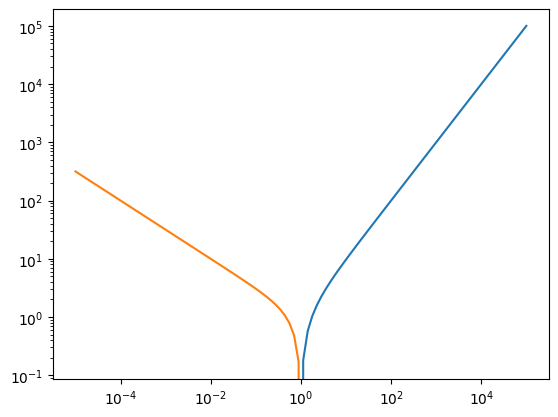

In [4]:
a = np.logspace(-5,5,100)
plt.loglog(a,a-1/np.sqrt(a))
plt.loglog(a,-a+1/np.sqrt(a))

/tmp/ipykernel_7059/931583564.py:144: RuntimeWarning: invalid value encountered in sqrt
  res= e + C1/(a*D) - 2 * C2 /D * np.sqrt(kappa/a**3) + 4 * kappa * gamma/a - 2*kappa*C1/(a**2*D) + 4*kappa/a * np.log(2/np.sqrt(a)) + 2*kappa*np.log(kappa)/a
/tmp/ipykernel_7059/931583564.py:15: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(x)
/tmp/ipykernel_7059/931583564.py:5: RuntimeWarning: invalid value encountered in power
  return np.power(x,k)
Exception ignored in: Traceback (most recent call last):
  File "classy.pyx", line 208, in classy.Class.struct_cleanup
TypeError: argument of type 'NoneType' is not iterable
'classy.Class.__dealloc__'
Traceback (most recent call last):
  File "classy.pyx", line 208, in classy.Class.struct_cleanup
TypeError: argument of type 'NoneType' is not iterable
Exception ignored in: 'classy.Class.__dealloc__'
Traceback (most recent call last):
  File "classy.pyx", line 208, in classy.Class.struct_cleanup
Traceback (most recent call last):
  

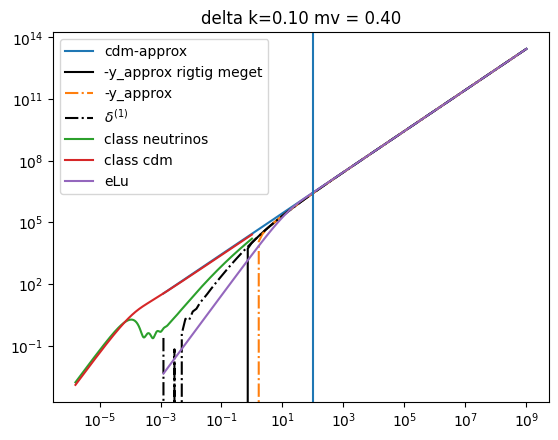

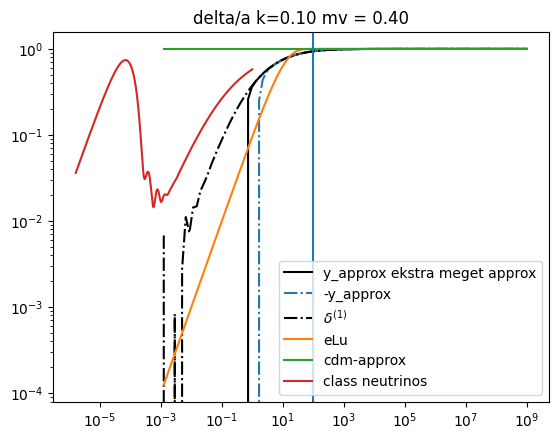

In [10]:
def TEST7(kvec=[1],k_ind=0,z=800,mv_test=1,Omega_M=0.99,
         Omega_b=0.01,PLOT_FIGUR=True,EdSitter=True,
         interpolation_type="cubic",H0_override=False,H=67):
    def Power(x,k):
        return np.power(x,k)
    def Cos(x):
        return np.cos(x)
    def Sin(x):
        return np.sin(x)
    def CosIntegral(x):
        return special.sici(x)[1]
    def SinIntegral(x):
        return special.sici(x)[0]
    def Sqrt(x):
        return np.sqrt(x)
    def Sinc(x):
        return np.sinc(x)
    def Log(x):
        return np.log(x)
    
    
    Omega_lambda = 1 - Omega_M - Omega_b
    cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
    cs_factor /= 8
    factor = cs_factor
    k = kvec[k_ind]
    H0=67
    if H0_override == True:
        H0 =H
    Tv_k = 1.947
    # in MeV
    h = 0.6704
    kb = 8.617e-11 # MeV/K
    T_0 = Tv_k * kb
    cosmo_dict ={'H0':H0, 'Omega_cdm':Omega_M,'Omega_b':Omega_b, 'k_output_values':str(kvec).strip('[]')
                 ,"N_ncdm":1,"m_ncdm":mv_test # massen er givet i eV s' jeg ganger min egen test m_v skal være en faktor  1e-6 mindre
               ,'output':'tCl, lCl, dTk, vTk, pCl', 'lensing':'yes',
                "ncdm_fluid_approximation":3
                , "YHe":0.25
                }
    c = 3*1e5 # speed of lign in km/s
    H0 /= c # i 1/Mpc
    cosmo = Class()
    cosmo.set(cosmo_dict)
    cosmo.compute()
    bg = cosmo.get_background()
    pts = cosmo.get_perturbations()['scalar'] 
    #k = tranf['k (h/Mpc)'] * h
    
    tid = bg['proper time [Gyr]'] * c / 306.4   
    kvec = np.array(kvec)
    mv = mv_test * 1e-6
    t0_test = tid[-1]
    def cs(a):
        Tv_k = 1.947 # kelvin # MeV
        kb = 8.617e-11 # MeV/K
        T_0 = Tv_k * kb
        mv = mv_test * 1e-6
        cs_factor = (25*special.zeta(5)/special.zeta(3))**0.5
        cs_factor /= 4
        cs_factor = 0.745*np.sqrt((4/11)**(2/3)*15*special.zeta(5)/special.zeta(3))
        return cs_factor *T_0 / a / mv
    c = cs(1)
    def test(kind,z_slut=0):
        c = cs(1)
        k = kvec[kind]
        delta_class = pts[kind]["delta_cdm"]
        theta_neutrino_class = pts[kind]["theta_ncdm[0]"]
        delta_neutrino_class = pts[kind]["delta_ncdm[0]"]        
        a_class = pts[kind]["a"]
        tau_class = pts[kind]["tau [Mpc]"]
        tid_class = scipy.interpolate.interp1d(bg['conf. time [Mpc]'],tid)(tau_class)
        interp_tid_from_a = scipy.interpolate.interp1d(a_class,tid_class,kind=interpolation_type,)
        delta_interp = scipy.interpolate.interp1d(tid_class,delta_class,kind=interpolation_type)        
        theta_neu_tid = scipy.interpolate.interp1d(tid_class,theta_neutrino_class)
        neu_tid = scipy.interpolate.interp1d(tid_class,delta_neutrino_class)        
        a0 = 1/(1+z)
        aslut = 1/(1+z_slut)
        t0 = interp_tid_from_a(aslut)
        T0 = float(interp_tid_from_a(a0)) # a0**(3/2) * t0
        delta0 = delta_interp(T0)  
        a_span = [a0,aslut] 
        a_test=np.logspace(np.log10(a0),9,100)
        tspan = [T0,t0]    
        bonus_tid = 1_000_000_000_000
        tid_test = np.logspace(np.log10(T0),np.log10(t0 * bonus_tid),100) 
        def f2(a,C1,C2):
            H0 = 2/(3*t0)
            #C1 = np.sqrt(neu_tid(T0)**2 + (theta_neu_tid(T0)*a0/ (cs(a0)*k))**2)
            #C2 =0.5* np.pi  * ( 2* cs(a0) * k  * a0 /H0)**2 * (delta0/a0)
            dcdm = delta0/a0  
            c = cs(1)
            val = 2 * c * k  / np.sqrt(a) / H0
            res = dcdm*a+C1*Cos(val) - C2*Sin(val) + val**2*a*dcdm* (Cos(val)*CosIntegral(val)+ Sin(val)*SinIntegral(val)) 
            return res      
        def func(a,y,D):
            d = y[0]
            d1 = y[1]
            d2 = 1/a**2 * (3/2 * a * D   - 3/2 * a * d1)
            return [d1,d2] 
        a = a_test
        a1 = a[:]       
        a_start = a0
        
        H0 = 2/(3*t0)
        C1 = np.sqrt(neu_tid(T0)**2 + (theta_neu_tid(T0)*a0/ (cs(a0)*k))**2)
        C2 =0.5* np.pi  * ( 2* cs(a0) * k  * a0 /H0)**2 * (delta0/a0)
        c1 = C1
        c2 = C2
        gamma = np.euler_gamma
        EulerGamma = gamma
        kappa = k**2 * cs(1)**2 / H0**2
        K = kappa  
        c1,c2 = C1,C2 
        a_x = (2*c2**2 * kappa +c1*(c1-gamma)*kappa+2*np.sqrt(c2**2*(c1**2+c2**2-c1*gamma)*kappa**2))/((c1-gamma)**2)
        D = delta0/a0
        e = 0.1
        a_x = 2*kappa/3 -c1/(6*e*D)  + (24*(c1**2+c2**2)*e*kappa*D/c1 +(c1-4*e*kappa*D)**2)/(3*2**(2/3)*e*D*(-2*c1**3-48*c1**2*e*kappa*D-72*c2**2*e*kappa*D-72*c2**2*e*kappa*D-240*c1*e**2*kappa**2*D**2+288*c2**2*e**2*kappa**2*D**2/c1+128*e**3*kappa**3*D**3+2*np.sqrt((c1*(c1**4+24*c1**3*e*kappa*D+36*c1*c2**2*e*kappa*D+128*c1**2*e**2*kappa*2*D**2-144*e**2*kappa**2*D**2-64*c1*e**3*kappa**3*D**3)**2-(24*(c1**2+c2**2)*e*kappa*D+c1*(c1-4*e*kappa*D)**2)**3)/(c1**3)))**(1/3)) +((-2*c1**3-48*c1**2*e*kappa*D-72*c2**2*e*kappa*D-72*c2**2*e*kappa*D-240*c1*e**2*kappa**2*D**2+288*c2**2*e**2*kappa**2*D**2/c1+128*e**3*kappa**3*D**3+2*np.sqrt((c1*(c1**4+24*c1**3*e*kappa*D+36*c1*c2**2*e*kappa*D+128*c1**2*e**2*kappa*2*D**2-144*e**2*kappa**2*D**2-64*c1*e**3*kappa**3*D**3)**2-(24*(c1**2+c2**2)*e*kappa*D+c1*(c1-4*e*kappa*D)**2)**3)/(c1**3)))**(1/3))/(6*2**(1/3)*e*D)
        a_x = (3*(64*Power(c1,2)*kappa + 75*Power(c2,2)*kappa +  5*Sqrt(3)*Sqrt(128*Power(c1,2)*Power(c2,2)*Power(kappa,2) +75*Power(c2,4)*Power(kappa,2))))/(32.*Power(c1,2))
        
        def function(a,C1,C2):
            res = a*delta0/a0 + C1 - 2 * np.sqrt(kappa/a) * C2 +delta0/a0 *(- 2 * kappa * C1 / a  + 4*gamma*kappa + kappa * np.log(16)+ 2 * kappa * np.log(kappa/a))
            D = delta0/a0
            D1 = D
            K = kappa
            res = a * D + C1 - 2 * C2 * np.sqrt(kappa/a) + 2*kappa/a * (2*a*D*gamma-C1+2*a*D*np.log(2/np.sqrt(a))+a*D*np.log(kappa))
            #res = a * D + C1 - 2 * C2 * np.sqrt(kappa/a) + 2*kappa/a * (2*a*D*gamma-C1 + a*D*np.log(4*a*kappa))
            res = a*D1 + C1 - (2*Sqrt(K)*C2)/Sqrt(a) + (4*Power(K,1.5)*C2)/(3.*Power(a,1.5)) - (4*Power(K,2.5)*C2)/(15.*Power(a,2.5)) + (2*K*(2*a*D1*EulerGamma - C1 + 2*a*D1*Log(2/Sqrt(a)) + a*D1*Log(K)))/a - (2*Power(K,2)*(-18*a*D1 + 12*a*D1*EulerGamma - C1 + 12*a*D1*Log(2/Sqrt(a)) + 6*a*D1*Log(K)))/(3.*Power(a,2)) + (2*Power(K,3)*(-125*a*D1 + 60*a*D1*EulerGamma - 2*C1 + 60*a*D1*Log(2/Sqrt(a)) + 30*a*D1*Log(K)))/(45.*Power(a,3))
            res = a*D1 + C1 - (2*Sqrt(K)*C2)/Sqrt(a) + (4*Power(K,1.5)*C2)/(3.*Power(a,1.5)) - (4*Power(K,2.5)*C2)/(15.*Power(a,2.5)) + (8*Power(K,3.5)*C2)/(315.*Power(a,3.5)) - (4*Power(K,4.5)*C2)/(2835.*Power(a,4.5)) + (2*K*(2*a*D1*EulerGamma - C1 + 2*a*D1*Log(2/Sqrt(a)) + a*D1*Log(K)))/a - (2*Power(K,2)*(-18*a*D1 + 12*a*D1*EulerGamma - C1 + 12*a*D1*Log(2/Sqrt(a)) + 6*a*D1*Log(K)))/(3.*Power(a,2)) + (2*Power(K,3)*(-125*a*D1 + 60*a*D1*EulerGamma - 2*C1 + 60*a*D1*Log(2/Sqrt(a)) + 30*a*D1*Log(K)))/(45.*Power(a,3)) - (2*Power(K,4)*(-686*a*D1 + 280*a*D1*EulerGamma - 5*C1 + 280*a*D1*Log(2/Sqrt(a)) + 140*a*D1*Log(K)))/(1575.*Power(a,4)) + (Power(K,5)*(-6849*a*D1 + 2520*a*D1*EulerGamma - 28*C1 + 2520*a*D1*Log(2/Sqrt(a)) + 1260*a*D1*Log(K)))/(99225.*Power(a,5))
            return res
        
        def function_1(a,C1,C2):
            D = delta0/a0
            D1 = D
            K = kappa
            res = a*D1 + C1 - (2*Sqrt(K)*C2)/Sqrt(a) + (4*Power(K,1.5)*C2)/(3.*Power(a,1.5)) - (4*Power(K,2.5)*C2)/(15.*Power(a,2.5)) + (2*K*(2*a*D1*EulerGamma - C1 + 2*a*D1*Log(2/Sqrt(a)) + a*D1*Log(K)))/a - (2*Power(K,2)*(-18*a*D1 + 12*a*D1*EulerGamma - C1 + 12*a*D1*Log(2/Sqrt(a)) + 6*a*D1*Log(K)))/(3.*Power(a,2)) + (2*Power(K,3)*(-125*a*D1 + 60*a*D1*EulerGamma - 2*C1 + 60*a*D1*Log(2/Sqrt(a)) + 30*a*D1*Log(K)))/(45.*Power(a,3))
            #res =  a*delta0/a0 + C1  - 2 * np.sqrt(kappa/a) * C2 - 2 * kappa * C1 / a+ 4*gamma*kappa #+ kappa * np.log(16)+ 2 * kappa * np.log(kappa/a)
            return res
        
        def function_2(a,C1,C2,e = 0.05):
            D = delta0/a0
            D1 = D
            K = kappa
            res= e + C1/(a*D) - 2 * C2 /D * np.sqrt(kappa/a**3) + 4 * kappa * gamma/a - 2*kappa*C1/(a**2*D) + 4*kappa/a * np.log(2/np.sqrt(a)) + 2*kappa*np.log(kappa)/a
            res = res = a*D1 + C1 - (2*Sqrt(K)*C2)/Sqrt(a) + (4*Power(K,1.5)*C2)/(3.*Power(a,1.5)) - (4*Power(K,2.5)*C2)/(15.*Power(a,2.5)) + (8*Power(K,3.5)*C2)/(315.*Power(a,3.5)) - (4*Power(K,4.5)*C2)/(2835.*Power(a,4.5)) + (2*K*(2*a*D1*EulerGamma - C1 + 2*a*D1*Log(2/Sqrt(a)) + a*D1*Log(K)))/a - (2*Power(K,2)*(-18*a*D1 + 12*a*D1*EulerGamma - C1 + 12*a*D1*Log(2/Sqrt(a)) + 6*a*D1*Log(K)))/(3.*Power(a,2)) + (2*Power(K,3)*(-125*a*D1 + 60*a*D1*EulerGamma - 2*C1 + 60*a*D1*Log(2/Sqrt(a)) + 30*a*D1*Log(K)))/(45.*Power(a,3)) - (2*Power(K,4)*(-686*a*D1 + 280*a*D1*EulerGamma - 5*C1 + 280*a*D1*Log(2/Sqrt(a)) + 140*a*D1*Log(K)))/(1575.*Power(a,4)) + (Power(K,5)*(-6849*a*D1 + 2520*a*D1*EulerGamma - 28*C1 + 2520*a*D1*Log(2/Sqrt(a)) + 1260*a*D1*Log(K)))/(99225.*Power(a,5))
            return res / (a*D)
        
        def function_3(a,C1,C2,e = 0.05):
            D = delta0/a0
            return e + C1/(a*D) - 2 * C2 /D * np.sqrt(kappa/a**3) + 4 * kappa * gamma/a - 2*kappa*C1/(a**2*D) + 4*kappa/a * np.log(2/np.sqrt(a)) + 2*kappa*np.log(kappa)/a
        
        def function_4(a,C1,C2):
            return  C1 - 2 * np.sqrt(kappa/a) * C2 +delta0/a0 *(- 2 * kappa * C1 / a  + 4*gamma*kappa + kappa * np.log(16)+ 2 * kappa * np.log(kappa/a))
        
        f_test = lambda a: a**4 * D**2 * e**2 + a**3 * e*2 * D * c1  + a**2 * (c1**2 -4 * kappa*D*c1*e)-4*a*kappa*(c2**2+c1**3)+4*kappa*c1**2
        fig = plt.figure(np.random.randint(1,10000)) 
        plt.title("delta k=%.2f mv = %.2f" % ( kvec[k_ind],mv_test))  
        b =-1# a * delta0/a0 
        c = -1# a_class/(delta0/a0) 
        plt.loglog(a,a*delta0/a0/b,label="cdm-approx")
        plt.loglog(a,function(a,C1,C2)/b,color="black",label="-y_approx rigtig meget")  
        plt.loglog(a,function_1(a,C1,C2)/b,"-.",label="-y_approx")
        plt.loglog(a,f2(a,C1,C2)/b,"-.",color="black",label=r"$\delta^{(1)}$")
        plt.loglog(a_class,delta_neutrino_class/c,label="class neutrinos")
        plt.loglog(a_class,delta_class/c,label="class cdm")
        
        
        x0 = fsolve(function_2,x0=100,args=(C1,C2,np.exp(-1)))
        plt.loglog(a,-a*delta0/a0*(1-np.exp(-a/(k*x0))),label="eLu")
        plt.axvline(x0)
        plt.legend()   
        plt.savefig("elu.png")
        #plt.yscale("linear")
        fig = plt.figure(np.random.randint(1,10000)) 
        plt.title("delta/a k=%.2f mv = %.2f" % ( kvec[k_ind],mv_test))  
        b = a * delta0/a0 
        c =  a_class*(delta0/a0) 
        plt.loglog(a,function(a,C1,C2)/b,color="black",label="y_approx ekstra meget approx")
        plt.loglog(a,function_1(a,C1,C2)/b,"-.",label="-y_approx")  
        
        plt.loglog(a,f2(a,C1,C2)/b,"-.",color="black",label=r"$\delta^{(1)}$")
        plt.loglog(a,(1-np.exp(-a/(k*x0))),label="eLu")
        plt.loglog(a,a*delta0/a0/b,label="cdm-approx")
        plt.loglog(a_class,delta_neutrino_class/c,label="class neutrinos") 
        plt.axvline(x0) 
        plt.legend()
        def g(a,ax):
            return 1 - np.exp(-a/ax)
        return None
    test(0)
    return None
#TEST7(kvec=[100],mv_test=1)   
#TEST7(kvec=[10],mv_test=1)  
TEST7(kvec=[.1],mv_test=0.4) 

/tmp/ipykernel_61/3081222102.py:143: RuntimeWarning: invalid value encountered in sqrt
  res= e + C1/(a*D) - 2 * C2 /D * np.sqrt(kappa/a**3) + 4 * kappa * gamma/a - 2*kappa*C1/(a**2*D) + 4*kappa/a * np.log(2/np.sqrt(a)) + 2*kappa*np.log(kappa)/a
/tmp/ipykernel_61/3081222102.py:15: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(x)
/tmp/ipykernel_61/3081222102.py:5: RuntimeWarning: invalid value encountered in power
  return np.power(x,k)
/tmp/ipykernel_61/3081222102.py:155: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(np.random.randint(1,10000))


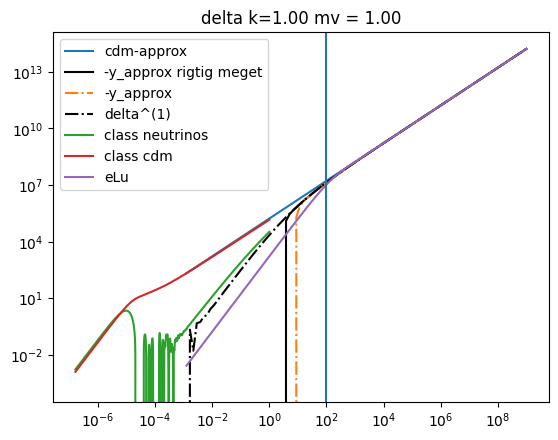

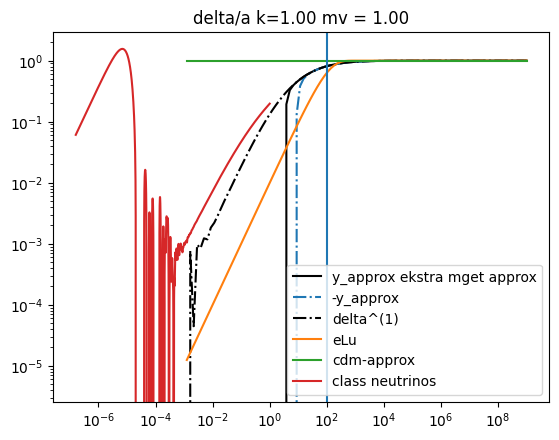

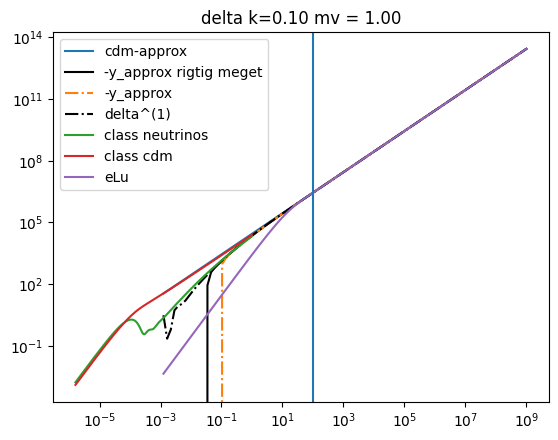

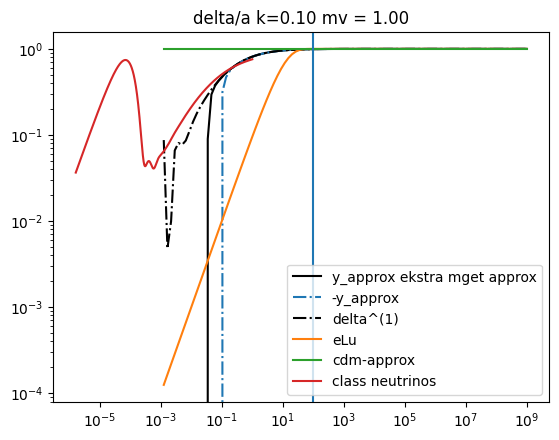

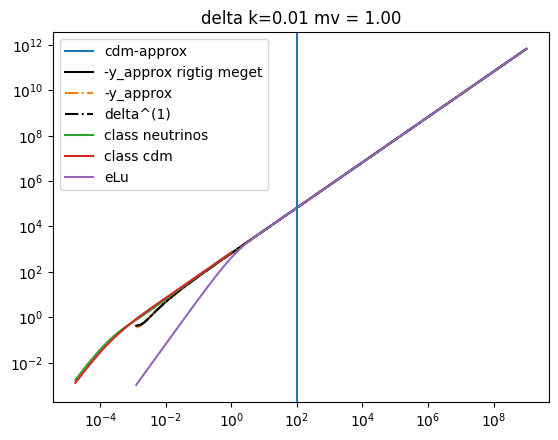

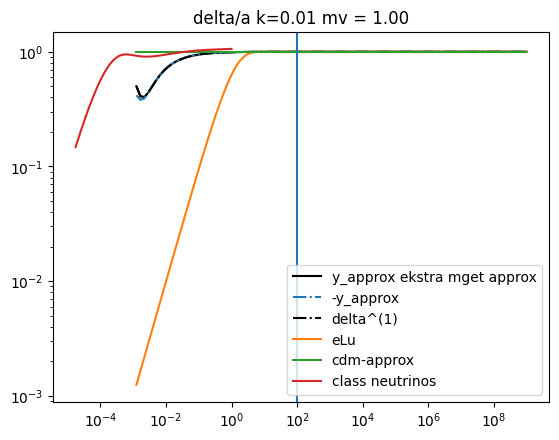

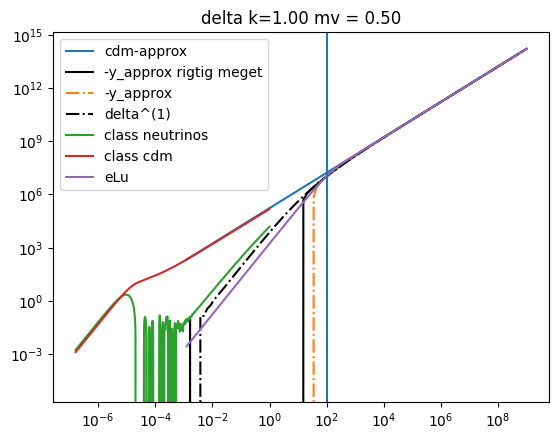

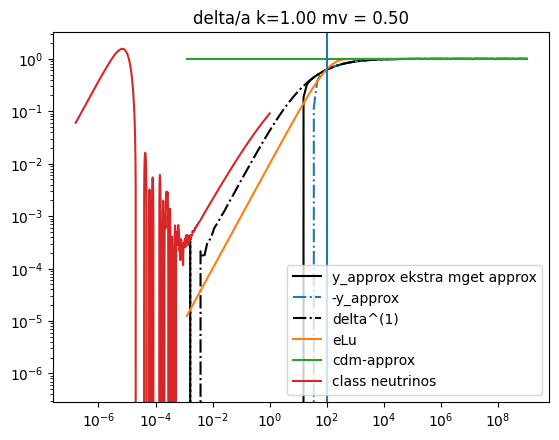

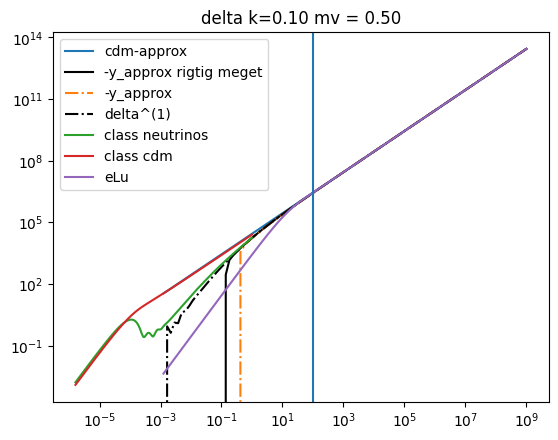

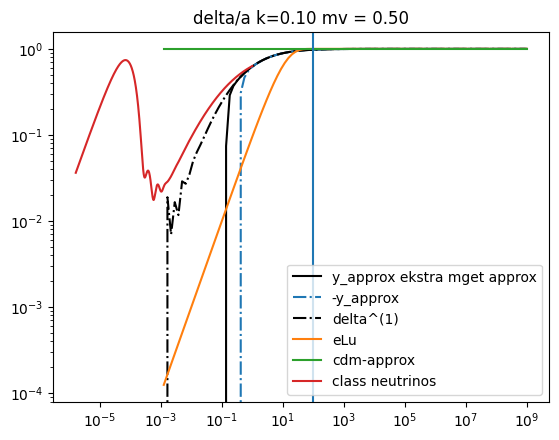

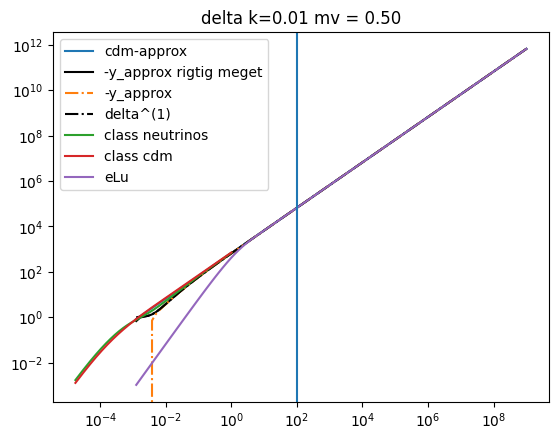

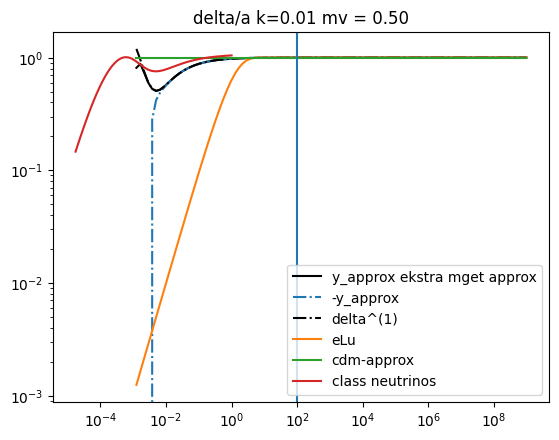

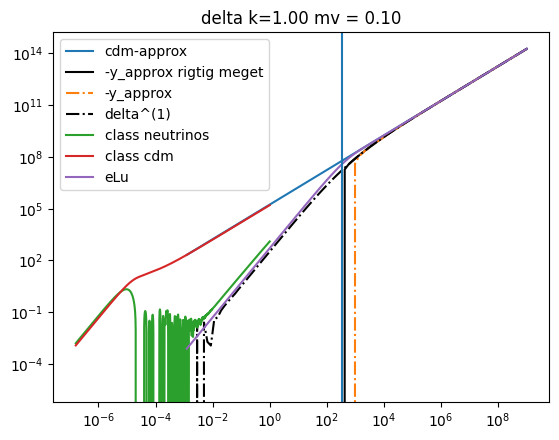

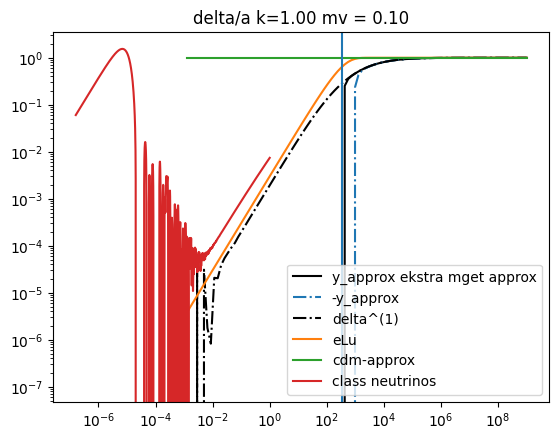

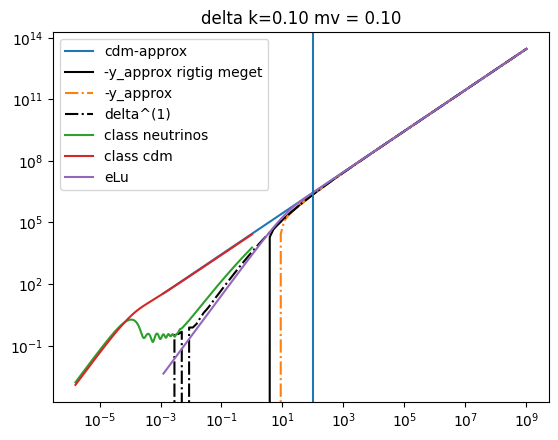

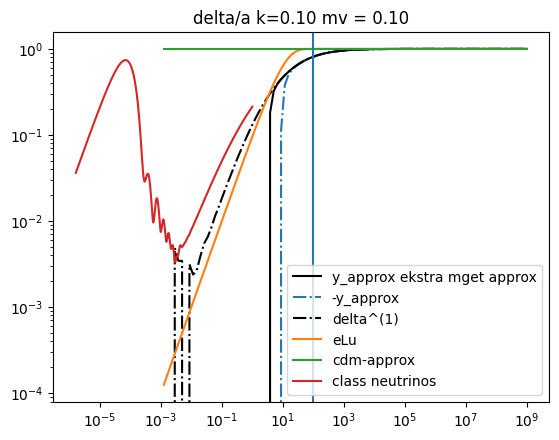

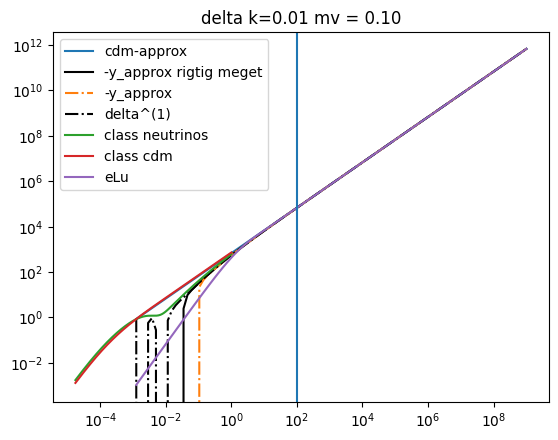

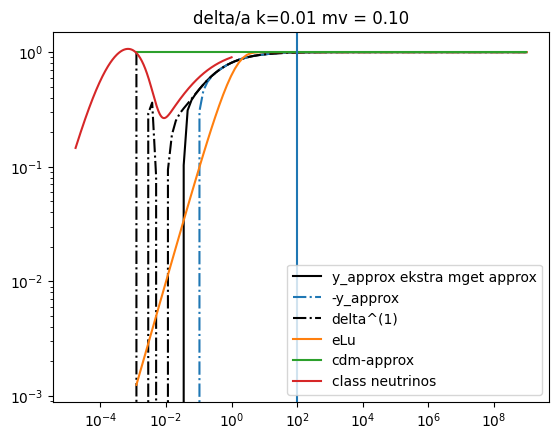

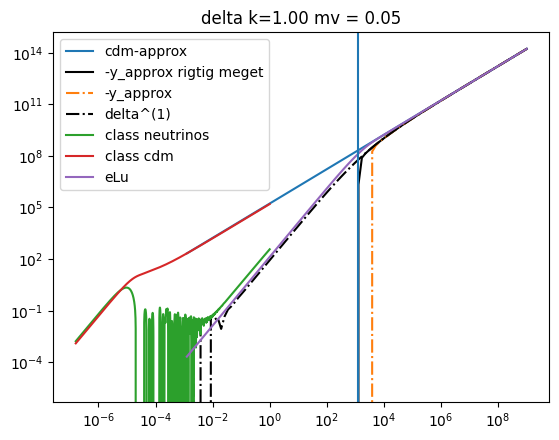

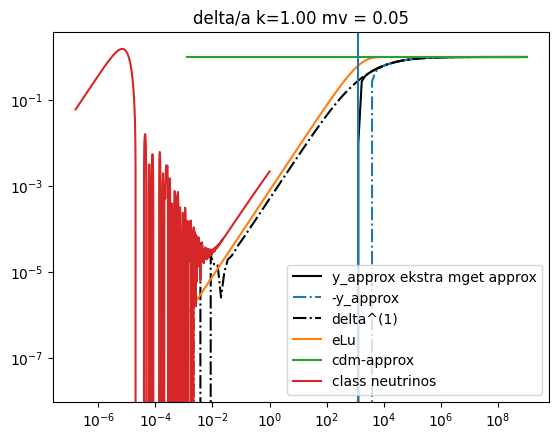

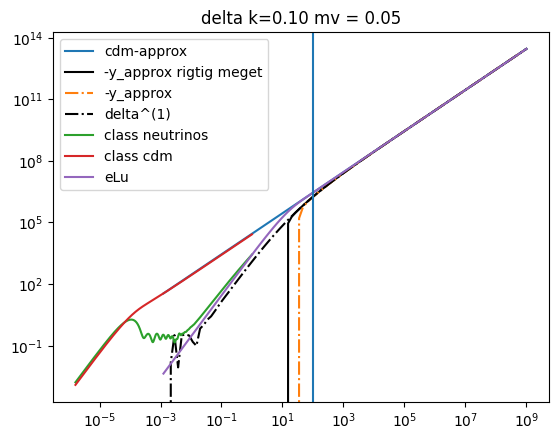

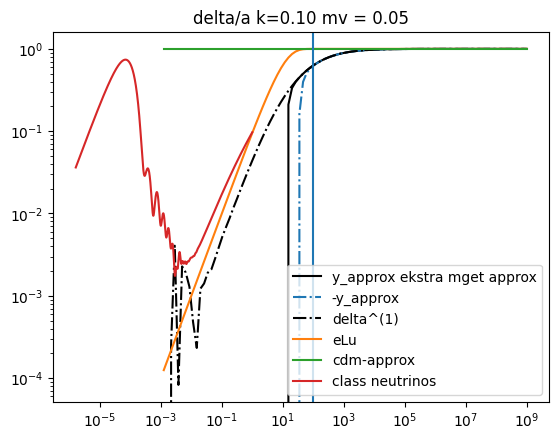

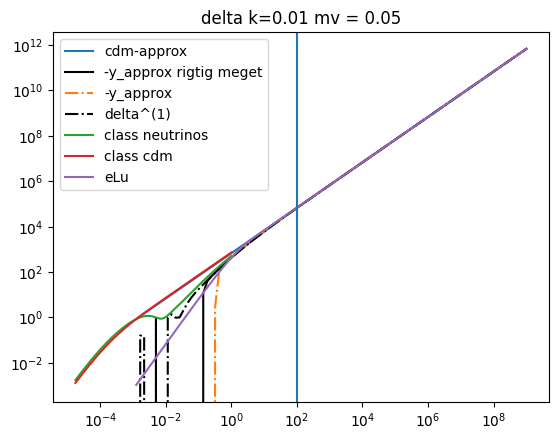

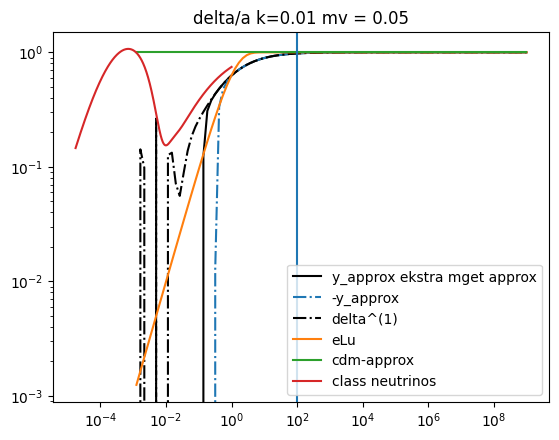

In [4]:
TEST7(kvec=[1],mv_test=1)   
TEST7(kvec=[.1],mv_test=1)  
TEST7(kvec=[.01],mv_test=1)  

TEST7(kvec=[1],mv_test=0.5)   
TEST7(kvec=[.1],mv_test=0.5)  
TEST7(kvec=[.01],mv_test=0.5)  

TEST7(kvec=[1],mv_test=0.1)   
TEST7(kvec=[.1],mv_test=0.1)  
TEST7(kvec=[.01],mv_test=0.1)  

TEST7(kvec=[1],mv_test=0.051)   
TEST7(kvec=[.1],mv_test=0.051)  
TEST7(kvec=[.01],mv_test=0.051)  
 

/tmp/ipykernel_61/3081222102.py:143: RuntimeWarning: invalid value encountered in sqrt
  res= e + C1/(a*D) - 2 * C2 /D * np.sqrt(kappa/a**3) + 4 * kappa * gamma/a - 2*kappa*C1/(a**2*D) + 4*kappa/a * np.log(2/np.sqrt(a)) + 2*kappa*np.log(kappa)/a
/tmp/ipykernel_61/3081222102.py:15: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(x)
/tmp/ipykernel_61/3081222102.py:5: RuntimeWarning: invalid value encountered in power
  return np.power(x,k)


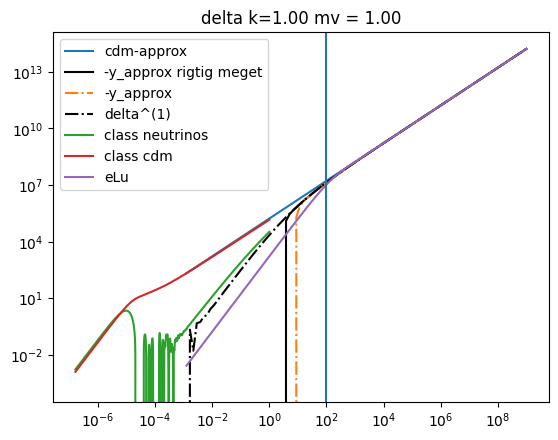

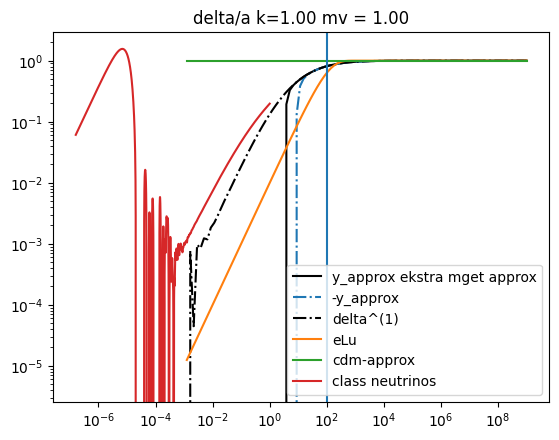

In [5]:
TEST7(kvec=[1],mv_test=1)   

In [37]:
1-np.exp(-1)

0.6321205588285577

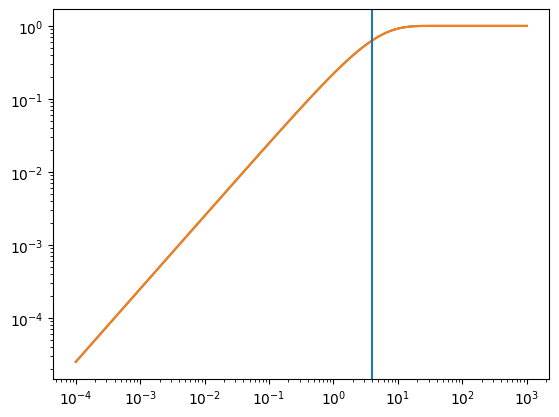

In [53]:
x0 = 4
t = np.logspace(-4,3,100)
plt.loglog(t,(1-np.exp(-t/x0)))
plt.loglog(t,(1-np.exp(-t/x0)))
plt.axvline(x0)